# Integrating human and mouse caudate snATAC-seq

Notes on linked peaks notes: 
- human peak w/ mouse ortholog intersecting human ortholog of mouse peak
- call ties w/ multiple peak matches using nearest summits
- count matrix comes from linked peaks 1-1 in human and mouse 

Notes on integration:
- perform integration with about same number of cells in each group
- here selected representative human and mouse subject
- predefine the features during anchor finding step

In [1]:
PROJDIR=file.path('../../../data/raw_data/mouse-human_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=14, repr.plot.height=6)
suppressMessages(library(Signac)); suppressMessages(library(Seurat))
suppressMessages(library(STACAS))

source('../hal_scripts/narrowPeakFunctions.R')
parallel::detectCores()

[1] 64

In [2]:
# # set up future for parallelization
library(future)
library(future.apply)
plan("sequential")
options(future.globals.maxSize = 250 * 1024^3)

# 1) visualize unintegrated species clusters

In [3]:
## load the seurat object
saveRDS_fn = file.path(PROJDIR, 'rdas', 'linkOrthologMatrixSeurat.rds')
obj_seurat = readRDS(file = saveRDS_fn)

In [4]:
##  TF-IDF, SVD, and UMAP already performed on 'peaks' matrix
obj_seurat
obj_seurat@meta.data$log10nFrags = log10(obj_seurat@meta.data$nFrags)

An object of class Seurat 
36983 features across 48680 samples within 1 assay 
Active assay: peaks (36983 features, 36983 variable features)
 2 dimensional reductions calculated: lsi, umap

In [5]:
## show cells per Species
table(obj_seurat@meta.data$Sample)

## show cell clusters per sample
table(obj_seurat@meta.data$Clusters2, obj_seurat@meta.data$Sample)


  06_0615.CAUD   09_1589.CAUD   14_1018.CAUD CEMBA171214_4D CEMBA171219_4D 
         10199           8672           7443           5082           5306 
CEMBA180813_5E CEMBA180820_5E 
          6283           5695 

             
              06_0615.CAUD 09_1589.CAUD 14_1018.CAUD CEMBA171214_4D
  Astro                436          391          417            412
  Interneuron          281          210          133            406
  Microglia            806          634          278            104
  MSN_D1              1191         1315          650           2669
  MSN_D2              1240         1497          746            194
  MSN_UNK1             378          189           11              0
  MSN_UNK2             389          126           16            758
  Mural                220          164           68             15
  Oligo               4651         3747         4952            380
  OPC                  582          367          160            140
  VLMC                  25           32           12              4
             
              CEMBA171219_4D CEMBA180813_5E CEMBA180820_5E
  Astro                  369            630            537
  Interneuron            451          

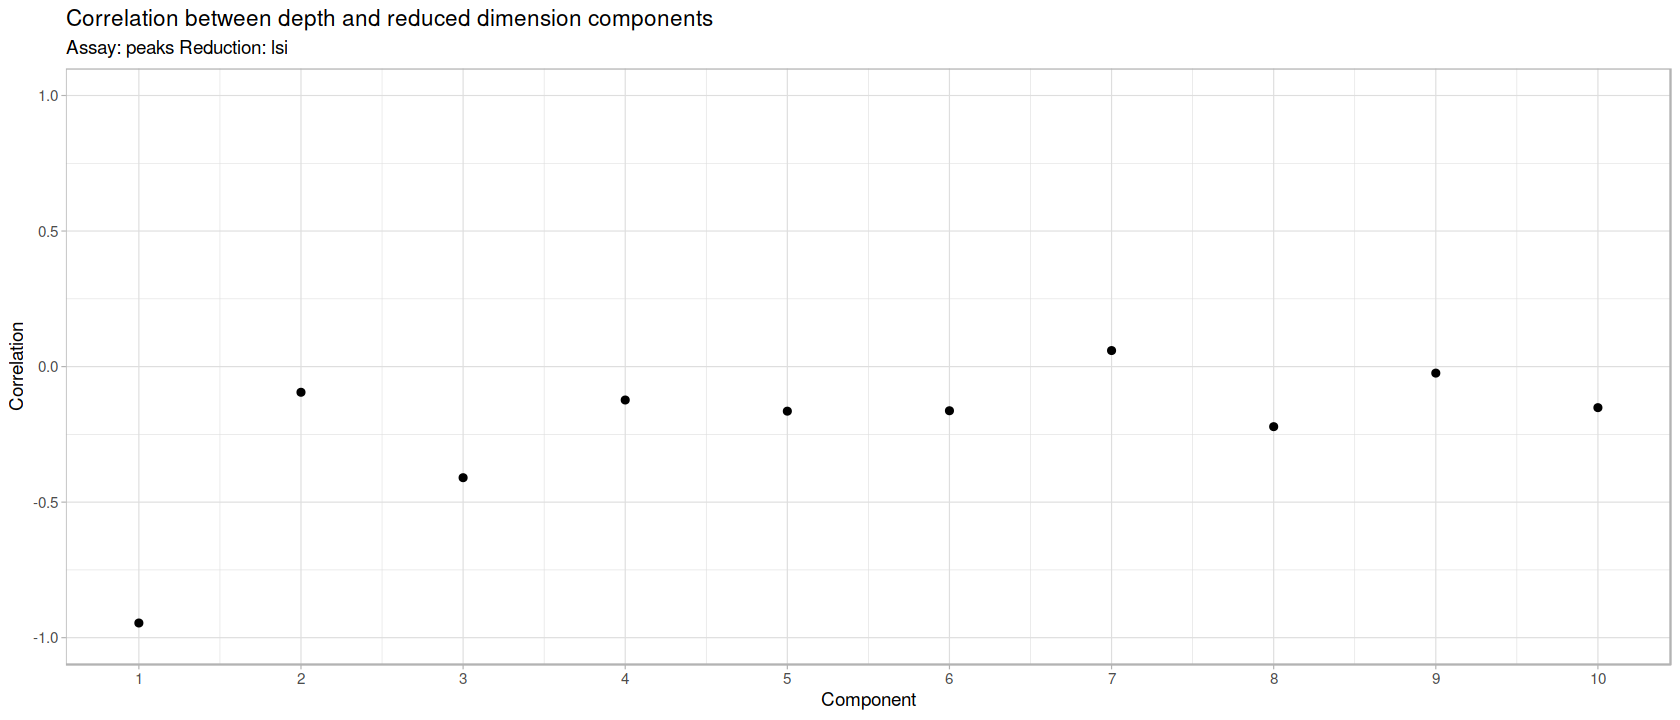

In [6]:
DepthCor(obj_seurat) # drop the first PC, correlated with number fragments

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


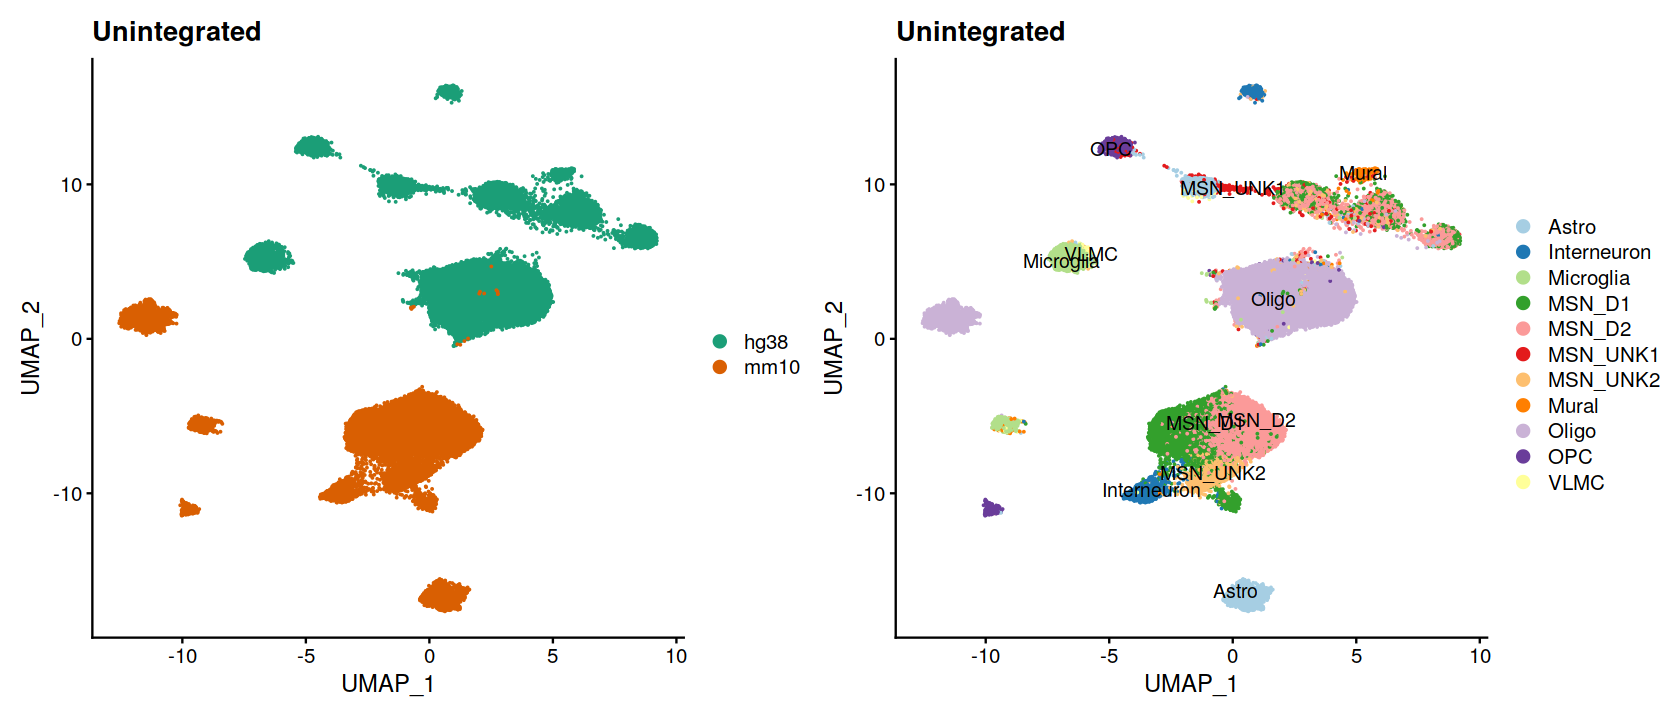

In [7]:
p_unintegrated_species = 
    DimPlot(object = obj_seurat, label = FALSE, group.by = 'Species', cols = 'Dark2') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_clusters2 = 
    DimPlot(object = obj_seurat, label = TRUE, group.by = 'Clusters2', cols = 'Paired') + 
    ggplot2::ggtitle("Unintegrated")

p_unintegrated_species + p_unintegrated_clusters2

# 2) integration with STACAS

In [ ]:
# find integration anchors between species, using all features
obj_seurat.list = SplitObject(obj_seurat, split.by = 'Sample')
print(names(obj_seurat.list))
obj_seurat.list = lapply(obj_seurat.list, function(x){
  x <- RunTFIDF(x, verbose = FALSE)
  x <- FindTopFeatures(x, min.cutoff = 'q5')
})

# features <- SelectIntegrationFeatures(object.list = obj_seurat.list, nfeatures = 10000)
features <- rownames(obj_seurat)

## compute SVD on all peaks
obj_seurat.list <- lapply(X = obj_seurat.list, FUN = function(x) {
    x <- RunSVD(x, features = features, verbose = FALSE)
})

anchors <- FindAnchors.STACAS( 
    object.list = obj_seurat.list, anchor.features = features,
    reference = c(1, 2), # using 09_1589.CAUD 14_1018.CAUD as reference
    assay = rep('peaks', dims=2:30, length(obj_seurat.list)))

anchors.filtered = FilterAnchors.STACAS(anchors)

rm(anchors); rm(obj_seurat.list); gc()

[1] "09_1589.CAUD"   "14_1018.CAUD"   "06_0615.CAUD"   "CEMBA180813_5E"
[5] "CEMBA171219_4D" "CEMBA171214_4D" "CEMBA180820_5E"


Preparing PCA embeddings for objects...



In [ ]:
# integrate data and create a new merged object
integrated <- IntegrateData(anchors.filtered, dims = 2:30, preserve.order = TRUE)

# we now have a "corrected" TF-IDF matrix, and can run LSI again on this corrected matrix
integrated <- RunSVD(integrated, n = 30, reduction.name = 'integratedLSI', verbose = FALSE)
integrated <- RunUMAP(integrated, dims = 2:30, reduction = 'integratedLSI', verbose = FALSE)

In [ ]:
# ## load the seurat object
# integratedRDS_fn = file.path(PROJDIR,'rdas','linkOrthologSeuratSTACAS.rds')
# integrated = readRDS(file = integratedRDS_fn)

In [ ]:
# plot embeddings
p_seuratIntegration_species = 
    DimPlot(object = integrated, label = FALSE, group.by = 'Species', cols = 'Dark2') +
    ggplot2::ggtitle('Seurat STACAS Integration')

p_seuratIntegration_clusters2 = 
    DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'Paired') +
    ggplot2::ggtitle('Seurat STACAS Integration')

p_seuratIntegration_species + p_seuratIntegration_clusters2

In [ ]:
## save the seurat object
integratedRDS_fn = file.path(PROJDIR,'rdas','linkOrthologSeuratSTACA.rds')
saveRDS(integrated, file = integratedRDS_fn)